#Ejemplo de clasificación multiclase con Keras + TensorFlow

##1. Subir el conjunto de datos a nuestro espacio en Colab
Lo primero que vamos a hacer es subir el fichero de datos que nos hemos descargado de la web de la asignatura a nuestro espacio en Colab.

Para ello ejecutamos el siguiente trozo de código y seleccionamos el fichero adecuado.

También podéis incorporarlo a vuestro Drive si activáis el acceso a Drive en el menú de la izquierda.

In [ ]:
from google.colab import files
files.upload()

Saving iris.data.txt to iris.data.txt


{'iris.data.txt': b'5.1, 3.5, 1.4, 0.2, 1\r\n4.9, 3, 1.4, 0.2, 1\r\n4.7, 3.2, 1.3, 0.2, 1\r\n4.6, 3.1, 1.5, 0.2, 1\r\n5, 3.6, 1.4, 0.2, 1\r\n5.4, 3.9, 1.7, 0.4, 1\r\n4.6, 3.4, 1.4, 0.3, 1\r\n5, 3.4, 1.5, 0.2, 1\r\n4.4, 2.9, 1.4, 0.2, 1\r\n4.9, 3.1, 1.5, 0.1, 1\r\n5.4, 3.7, 1.5, 0.2, 1\r\n4.8, 3.4, 1.6, 0.2, 1\r\n4.8, 3, 1.4, 0.1, 1\r\n4.3, 3, 1.1, 0.1, 1\r\n5.8, 4, 1.2, 0.2, 1\r\n5.7, 4.4, 1.5, 0.4, 1\r\n5.4, 3.9, 1.3, 0.4, 1\r\n5.1, 3.5, 1.4, 0.3, 1\r\n5.7, 3.8, 1.7, 0.3, 1\r\n5.1, 3.8, 1.5, 0.3, 1\r\n5.4, 3.4, 1.7, 0.2, 1\r\n5.1, 3.7, 1.5, 0.4, 1\r\n4.6, 3.6, 1, 0.2, 1\r\n5.1, 3.3, 1.7, 0.5, 1\r\n4.8, 3.4, 1.9, 0.2, 1\r\n5, 3, 1.6, 0.2, 1\r\n5, 3.4, 1.6, 0.4, 1\r\n5.2, 3.5, 1.5, 0.2, 1\r\n5.2, 3.4, 1.4, 0.2, 1\r\n4.7, 3.2, 1.6, 0.2, 1\r\n4.8, 3.1, 1.6, 0.2, 1\r\n5.4, 3.4, 1.5, 0.4, 1\r\n5.2, 4.1, 1.5, 0.1, 1\r\n5.5, 4.2, 1.4, 0.2, 1\r\n4.9, 3.1, 1.5, 0.1, 1\r\n5, 3.2, 1.2, 0.2, 1\r\n5.5, 3.5, 1.3, 0.2, 1\r\n4.9, 3.1, 1.5, 0.1, 1\r\n4.4, 3, 1.3, 0.2, 1\r\n5.1, 3.4, 1.5, 0.2, 1\r\n5, 3

## 2. Importar librerías necesarias
Ahora vamos a instalar las librerías necesarias para dibujar la red gráficamente. Estas librerías no son imprescindibles, pero vamos a incorporarlas para utilizar una función de keras que nos permitirá ver de manera gráfica la red creada.

Después cargaremos las librerías que sí son imprescindibles.



In [ ]:
#Instalar librerias para dibujar la red gráficamente
!pip install pydot
!apt-get install graphviz

#Cargar librerias necesarias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


## 3. Creación de la red y funciónes auxiliares

En esta ocasión, vamos a organizar el código en funciones.

La primera función es **plot_history**, que como sucedía en el problema de regresión, la utilizaremos para dibujar la gráfica en la que se ve la evolución del error durante ele entrenamiento.

La segunda función se ocupa de i) crear la red, ii) seleccionar el optimizador e inicializar parámetros, y iii) realizar el aprendizaje mostrando gráficamente la evolución del error.

Cabe destacar en este apartado que la capa de salida tiene tantas celdas como número de clases. Además, fíjate que en la capa de salida, la función de activación es la función **softmax**.

Fíjate también en la función que se optimiza: **categorical_crossentropy**. Si consultas la ayuda, verás que es la función que se corresponde con la función de pérdida para los problemas multiclase.


**Nota**: la creación de la red podría haberse sacado de esta función puesto que únicamente se necesita crear la primera vez. Sin embargo, para que los resultados sean reproducibles se necesita que los parámetros iniciales del modelo sean los mismos en cada ejecución. Podría haberse logrado usando varias funciones, pero hemos decidido sacrificar un poco la eficiencia en aras de aumetar la claridad.




In [ ]:
def plot_history(history, validation=False):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('categorical_crossentropy')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    if validation:
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label='Validation Loss')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])


def entrena(X, Y, learning_rate=0.001, batch_size=32, epochs=1000, validation_data=None):
    """Función que crea la red, define el modelo y entrena"""

    """ SE CREA LA RED """
    # Fijar semillas de números aleatorios
    np.random.seed(100)
    tf.keras.utils.set_random_seed(100)

    n_input = 4  # Celdas en la capa de entrada (features)
    n_hidden1 = 12  # Celdas en la primera capa oculta
    n_hidden2 = 10  # Celdas en la segunda capa oculta
    n_hidden3 = 8  # Celdas en la tercera capa oculta
    n_clases = 3  # Celdas en la capa de salida

    # Definir las capas del modelo
    model = Sequential()
    model.add(Dense(n_hidden1, input_dim=n_input, activation='relu', name="hidden1_layer"))
    model.add(Dense(n_hidden2, activation='relu', name="hidden2_layer"))
    model.add(Dense(n_hidden3, activation='relu', name="hidden3_layer"))
    model.add(Dense(n_clases, activation='softmax', name="output_layer"))

    # Como se puede ver, se crea un modelo secuencial donde cada capa añadida
    # recibe como entrada la salida de la anterior.
    # La dimensión de la entrada siempre se define en la primera capa del modelo
    # (parámetro input_dim) => model.add(Dense(n_hidden1, input_dim=n_input, name="hidden1_layer"))

    # Existe también una forma "funcional" de crear modelos. En este caso sería:
    # in_layer = Input(shape =(n_input,))
    # hidden1_layer = Dense(n_hidden1, name="hidden1_layer",activation='relu')(in_layer)
    # hidden2_layer = Dense(n_hidden2, name="hidden2_layer",activation='relu')(hidden1_layer)
    # hidden3_layer = Dense(n_hidden3, name="hidden3_layer",activation='relu')(hidden2_layer)
    # out_layer = Dense(n_output, name="out_layer")(hidden3_layer)
    #
    # model = Model(inputs = [in_layer], outputs = [out_layer])

    """ SELECCIONAR OPTIMIZADOR E INICIALIZAR PARÁMETROS """
    # Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
    sgd = SGD(learning_rate=learning_rate)

    # Compilar el modelo indicando la función de pérdida (loss) y el optimizador
    model.compile(loss='categorical_crossentropy', optimizer=sgd)

    """ SE VISUALIZA EL MODELO """
    # Imprimir en modo texto finalmente el resumen/arquitectura de nuestro modelo
    # Esta información permite conocer el número de parámetros que se han de aprender
    model.summary()

    # Obtener un fichero con la representación gráfica del modelo
    plot_model(model, to_file='model.png')
    # Después de ejecutar esta línea se genera el fichero 'model.png'. Para poder
    # verlo, tienes que ir a la parte izquierda, acceder a la pestaña 'Archivos' y
    # 'actualizar', aparecerá entonces el archivo y podrás verlo (doble click sobre
    # el fichero 'model.png' o click con el botón derecho para descargarlo)

    """ SE ENTRENA """
    # Entrenar el modelo a partir de los ejemplos de TRAIN creados en el punto 2
    history = model.fit(X, Y, verbose=0, batch_size=batch_size, epochs=epochs,
                        validation_data=validation_data)
    traza_train = np.array(history.history['loss'])
    print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
    print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
    print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))
    if validation_data is not None:
      traza_val = np.array(history.history['val_loss'])
      print("-- Mínimo error VALIDACION: {:.6f}".format(min(traza_val)))
      print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_val[-10:])))
      print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_val[-10:])))
    plot_history(history, validation=(validation_data is not None))

## 4. Cargar el conjunto

El conjunto está en el fichero **iris.data.txt**. Contiene datos de 150 lirios pertenecientes a 3 clases diferentes. Cada lirio viene descrito por cuatro atributos.

Lo primero que hacemos es cargar el conjuto en un dataframe de pandas y barajar los ejemplos.

Después almacenamos en una matriz (laX) la descripción de los lirios y en un vector (laY) la clase de los mismos.

La clase, tal y como nos viene en el conjunto de datos, no puede ser utilizada directamente en la red. Necesitamos su codificación **one_hot**. Para obtenerla, vamos a utilizar una función de keras que se llama **to_categorical** y que crea una columna para cada clase empezando siempre en el 0. Consulta la ayuda para entender cómo funciona.


In [ ]:
# Se carga el conjunto de datos de los lirios. Cada lirio está descrito
# mediante 4 atributos y viene acompañado de su clase.
# Fíjate que la clase está en la última columna y solo puede ser 0, 1 o 2.
df = pd.read_csv('iris.data.txt',
                 names=['Sepal_length', 'Sepal_width', 'Petal_length',
                        'Petal_width', 'clase'],
                 dtype=np.float32)

# Se barajan los ejemplos
df = df.sample(frac=1, random_state=100).reset_index(drop=True)

# La descripción de los lirios se almacena en 'laX' y la clase en 'laY'
laX = df.iloc[:, :-1]  # todas las columnas salvo las última
laY = df.iloc[:, -1:]  # la última columa es la clase

# Es necesario utilizar la codificación one-hot para codificar la clase.
# Esta codificación podemos obtenerla usando la función 'to_categorical' de
# 'keras.utils'. Consulta la ayuda para entender cómo funciona
laY_one_hot = to_categorical(laY)
print(laX)
print(laY_one_hot)


     Sepal_length  Sepal_width  Petal_length  Petal_width
0             6.4          2.8           5.6          2.1
1             4.8          3.4           1.6          0.2
2             7.7          2.6           6.9          2.3
3             5.7          4.4           1.5          0.4
4             6.3          2.7           4.9          1.8
..            ...          ...           ...          ...
145           6.3          2.3           4.4          1.3
146           6.3          2.9           5.6          1.8
147           5.8          2.7           4.1          1.0
148           4.8          3.4           1.9          0.2
149           4.4          2.9           1.4          0.2

[150 rows x 4 columns]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0.

## 4. Entrenar el modelo
Una vez que  hemos definido cómo va a ser nuestro modelo y que tenemos el conjunto de datos preparado, vamos a entrenarlo para buscar los parámetros que hagan mínima la función de pérdida.

Para ello vamos a llamar a la función **entrena** que definimos anteriormente. Necesita que le suministremos los ejemplos (laX, laY_one_hot), el learning rate, el tamaño del batch y el número de epochs.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_layer (Dense)       (None, 6)                 30        
                                                                 
 hidden2_layer (Dense)       (None, 5)                 35        
                                                                 
 hidden3_layer (Dense)       (None, 4)                 24        
                                                                 
 output_layer (Dense)        (None, 3)                 15        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
-- Mínimo error TRAIN: 0.706723
      Media 10 últimas epochs: ** 0.707819 **
      Desv. 10 últimas epochs: 0.000607


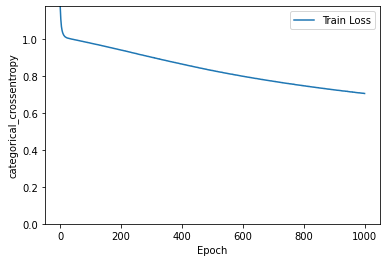

In [ ]:
# se entrena
learning_rate = 0.001  # learning rate
tam_batch = 32   # Tamaño del batch
n_epochs = 1000  # Número de epochs
entrena(laX, laY_one_hot, learning_rate, tam_batch, n_epochs)

##5. Efecto del learning rate
El resultado que se obtiene en esta ejecución no es muy bueno, ya que en la gráfica se ve que el error ha bajado un poco y luego se ha estancado en torno a 0.979.

Esto puede deberse a que el ratio de aprendizaje (learning rate) es demasiado pequeño. Prueba a cambiarlo asignándole el valor 0.001 y vuelve a ejecutar la función. Ahora se ve que la curva está bajando y al alcanzar el número de epochs tiene un error en torno a 0.71. Viendo la forma de la gráfica se ve que todavía podría seguir bajando.

Aumenta nuevamente el learning rate asignándole 0.01 y ejecuta. La curva ahora baja más rápidamente y llegado un punto comienza a oscilar, pero finaliza con una loss mejor.

Si seguimos aumentando el learning rate (0.05)  vemos que baja rápidamente y que hay muchas oscilaciones.

Si probamos con learning rate 0.1, vemos que el algoritmo no es capaz de alcanzar una buena solución.

Durante el entrenamiento de una red, hay que tener especial cuidado con el valor del learning rate. Será necesario buscar el valor que más se adecúe a nuestro problema y nuestra red.

Sin embargo, que el uso de un learning rate haga que se obtengan mejores o peores resultados, depende también de otros factores, como por ejemplo el número de epochs. Si utilizamos un número de epochs más grande, le daremos más tiempo al algoritmo y, tal vez, valores de learnig rate más bajos vayan haciendo mínimo el error de una manera más lenta y segura.

##6. El tamaño del batch

La evolución del modelo durante el aprendizaje también depende del tamaño del batch. Tamaños de batch más pequeños aceleran el aprendizaje, ya que un tamaño pequeño implica que se harán más actualizaciones en cada epoch. Sin embargo, tamaños de batch demasiado pequeños pueden provocar inestabilidad en el aprendizaje cuando nos enfrentamos a problemas con mucho ruido.

Por ejemplo, con un tamaño de batch 32 y 1000 epochs, sabiendo que tenemos 150 ejemplos, se están haciendo `ceil(150/32)x1000=5000` actualizaciones de los parámetros. Si pruebas esta configuración con un learning rate de 0.001 deberías obtener un resultado en torno a 0.71.

Si bajas el tamaño del batch a 16, se harán `ceil(150/16)x1000=10000` actualizaciones de los parámetros y el error bajará más rápido (0.59).

Si bajas el tamaño del batch a 8, se harán `ceil(150/8)x1000=19000` actualizaciones de los parámetros y el error bajará aún más (0.38).

Si pruebas con batch 2, se harán `ceil(150/2)x1000=75000` actualizaciones de los parámetros y el error bajará hasta (0.06).


##7. Entrenamiento y validación
Todas las curvas que hemos visto se corresponden con la evolución del error en el conjunto de entrenamiento. Fijándonos sólo en estas curvas corremos el riesgo de caer en el **sobreajuste**. Así que vamos a separar unos pocos ejemplos como conjunto de validación y así podremos ver la evolución del modelo ante casos no vistos.

Psrs ello vamos a utilizar la función *train_test_split* de la librería *sklearn*. Tal y como está llamada la función en el siguiente trozo de código, se reservará un 10% de ejemplos para el conjunto de validación. El parámetro *stratify* garantiza que se mantenga en el conjunto de validación la misma distribución que en el conjunto de entrenamiento.



In [ ]:
# Separar en entrenamiento y validación
from sklearn.model_selection import train_test_split
x_train, x_val, yoh_train, yoh_val = train_test_split(laX, laY_one_hot,
                                                      test_size=0.1, stratify=laY)

print(x_train.shape)
print(yoh_train.shape)
print(x_val.shape)
print(yoh_val.shape)

(135, 4)
(135, 3)
(15, 4)
(15, 3)


Vemos que los 150 lirios disponibles se han separado en 135 para entrenar y 15 para validar. Vamos ahora a ver las dos curvas a la vez repitiendo las ejecuciones del apartado **5. Efecto del learning rate**.

Verás que para algunos learning rates las dos curvas van de la mano, sin embargo, cuando somos muy agresivos, el modelo se ajusta bien al conjunto de entrenamiento y el resultado en la validación es muy oscilante. Estamos, en tal caso, ante un modelo poco fiable (o ante un mal conjunto de validación).

Ejecútalo ahora con `learning_rate=0.001`, `tam_batch=16` y `n_epochs=6000`. Tardará un poco más en aparecer la gráfica.

Esto es aceptable si la diferencia es pequeña. Si la diferencia es grande puede deberse a que tenemos un conjunto de validación que no representa bien los casos nos vistos (porque sea pequeño, por ejemplo) o a que nos estamos sobreajustando. Vemos que a partir de cierto momento, aunque el error en entrenamiento sigue bajando, el error en validación deja de bajar y se vuelve muy inestable.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_layer (Dense)       (None, 6)                 30        
                                                                 
 hidden2_layer (Dense)       (None, 5)                 35        
                                                                 
 hidden3_layer (Dense)       (None, 4)                 24        
                                                                 
 output_layer (Dense)        (None, 3)                 15        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
-- Mínimo error TRAIN: 0.076517
      Media 10 últimas epochs: ** 0.079116 **
      Desv. 10 últimas epochs: 0.001716
-- Mínimo error VALIDACION: 0.085038
      Media 10 últimas epochs: **

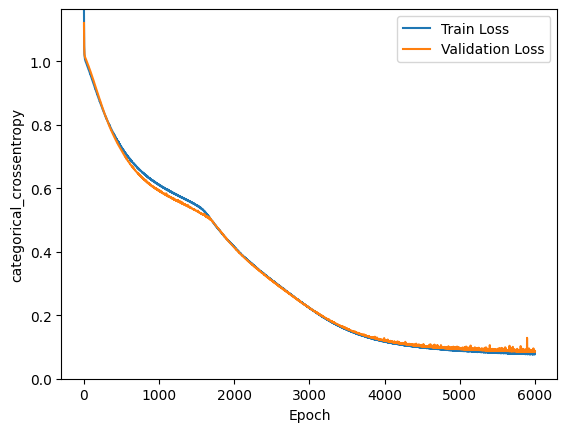

In [ ]:
learning_rate = 0.001  # learning rate
tam_batch = 16   # Tamaño del batch
n_epochs = 6000  # Número de epochs

entrena(x_train, yoh_train, learning_rate, tam_batch, n_epochs, validation_data=(x_val, yoh_val))

El conjunto de los lirios se resuelve mediante relaciones que no son muy complicadas, por eso, utilizar muchas capas ocultas y muchas celdas en estas capas puede llevarnos a sobreajustarnos.

Puedes probar a añadir capas (o quitarlas) al modelo y ver qué efecto tiene en el aprendizaje.